# STARfinder I/O Module - Interactive Testing

This notebook demonstrates the I/O functions implemented in `starfinder.io`:
- `load_multipage_tiff` - Load a multi-page TIFF file
- `load_image_stacks` - Load multiple channel TIFFs from a directory
- `save_stack` - Save a 3D/4D array as a multi-page TIFF

In [1]:
import sys
from pathlib import Path

# Add the Python package to path
sys.path.insert(0, str(Path("../src/python").resolve()))

import numpy as np
import matplotlib.pyplot as plt
from starfinder.io import load_multipage_tiff, load_image_stacks, save_stack

print(f"starfinder loaded from: {Path('../src/python').resolve()}")

starfinder loaded from: /home/unix/jiahao/Github/src/python


## 1. Test with Synthetic Data

First, let's test with the synthetic test dataset that was generated.

In [2]:
# Check available synthetic test data
fixtures_dir = Path("tests/fixtures/synthetic")
print("Available test datasets:")
for d in fixtures_dir.iterdir():
    if d.is_dir():
        print(f"  - {d.name}")

Available test datasets:
  - standard
  - mini


In [3]:
# Load a single TIFF from the mini dataset
mini_dir = fixtures_dir / "mini"
round1_dir = mini_dir / "FOV_001" / "round1"

print(f"Files in {round1_dir}:")
for f in sorted(round1_dir.glob("*.tif")):
    print(f"  - {f.name}")

Files in tests/fixtures/synthetic/mini/FOV_001/round1:
  - ch00.tif
  - ch01.tif
  - ch02.tif
  - ch03.tif


In [6]:
# Load a single channel TIFF
tiff_path = round1_dir / "ch01.tif"
img = load_multipage_tiff(tiff_path, convert_uint8=False)

print(f"Loaded image shape: {img.shape}")
print(f"Loaded image dtype: {img.dtype}")
print(f"Value range: [{img.min()}, {img.max()}]")

Loaded image shape: (5, 256, 256)
Loaded image dtype: uint8
Value range: [0, 255]


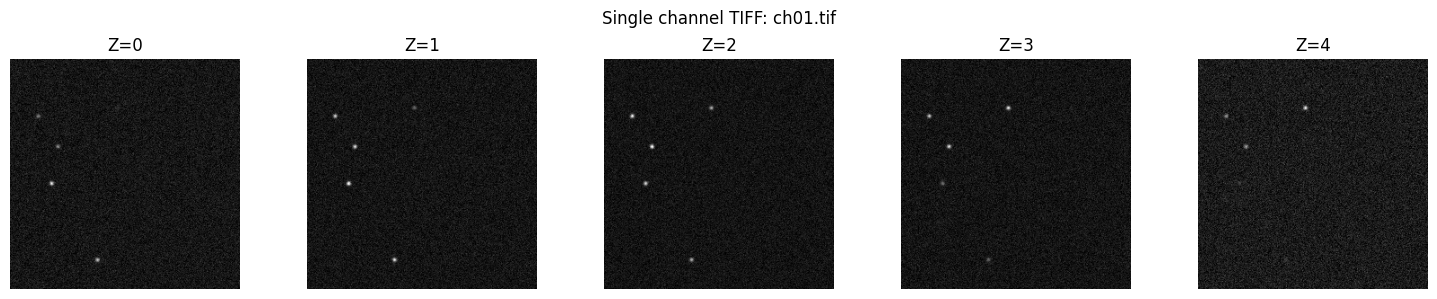

In [7]:
# Visualize Z slices
n_slices = min(img.shape[0], 6)
fig, axes = plt.subplots(1, n_slices, figsize=(3*n_slices, 3))
if n_slices == 1:
    axes = [axes]
    
for i, ax in enumerate(axes):
    ax.imshow(img[i], cmap='gray')
    ax.set_title(f'Z={i}')
    ax.axis('off')
    
plt.suptitle(f'Single channel TIFF: {tiff_path.name}')
plt.tight_layout()
plt.show()

## 2. Load Multi-Channel Image Stack

Load all channels from a round directory using `load_image_stacks`.

In [8]:
# Load all 4 channels
channel_order = ["ch00", "ch01", "ch02", "ch03"]
stack, metadata = load_image_stacks(round1_dir, channel_order, convert_uint8=False)

print(f"Stack shape: {stack.shape}  # (Z, Y, X, C)")
print(f"Stack dtype: {stack.dtype}")
print(f"Metadata: {metadata}")

Stack shape: (5, 256, 256, 4)  # (Z, Y, X, C)
Stack dtype: uint8
Metadata: {'shape': (5, 256, 256, 4), 'dtype': 'uint8', 'original_shapes': [(5, 256, 256), (5, 256, 256), (5, 256, 256), (5, 256, 256)], 'cropped': False}


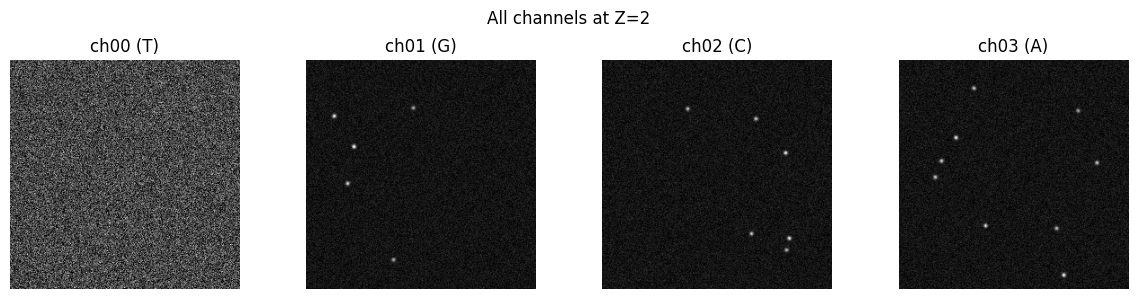

In [9]:
# Visualize all channels at a single Z slice
z_slice = stack.shape[0] // 2  # middle slice

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
channel_names = ["ch00 (T)", "ch01 (G)", "ch02 (C)", "ch03 (A)"]

for i, (ax, name) in enumerate(zip(axes, channel_names)):
    ax.imshow(stack[z_slice, :, :, i], cmap='gray')
    ax.set_title(name)
    ax.axis('off')

plt.suptitle(f'All channels at Z={z_slice}')
plt.tight_layout()
plt.show()

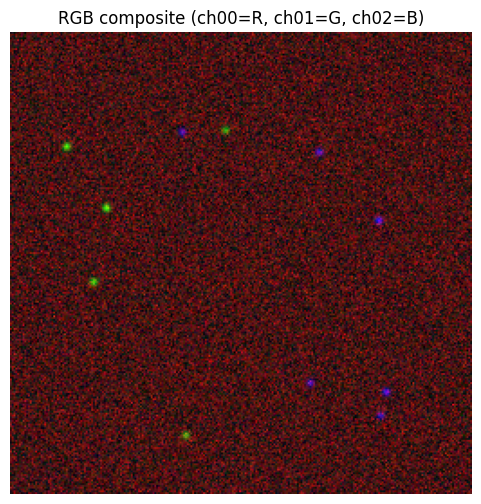

In [10]:
# Create RGB composite (first 3 channels)
z_slice = stack.shape[0] // 2

# Normalize each channel to 0-1
rgb = np.zeros((stack.shape[1], stack.shape[2], 3), dtype=np.float32)
for i in range(3):
    ch = stack[z_slice, :, :, i].astype(np.float32)
    if ch.max() > ch.min():
        rgb[:, :, i] = (ch - ch.min()) / (ch.max() - ch.min())

plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title('RGB composite (ch00=R, ch01=G, ch02=B)')
plt.axis('off')
plt.show()

## 3. Test uint8 Conversion

In [11]:
# Load with uint8 conversion (default)
stack_uint8, _ = load_image_stacks(round1_dir, channel_order, convert_uint8=True)

print(f"Original dtype: {stack.dtype}, range: [{stack.min()}, {stack.max()}]")
print(f"Converted dtype: {stack_uint8.dtype}, range: [{stack_uint8.min()}, {stack_uint8.max()}]")

Original dtype: uint8, range: [0, 255]
Converted dtype: uint8, range: [0, 255]


## 4. Save and Reload Test

In [13]:
import tempfile

# Use the actual mini dataset we loaded earlier
test_data = stack[:, :, :, 0]  # First 5 Z-slices, first channel

# Save to temp file
with tempfile.TemporaryDirectory() as tmp_dir:
    tmp_path = Path(tmp_dir) / "test_output.tif"
    
    # Save without compression
    save_stack(test_data, tmp_path, compress=False)
    size_uncompressed = tmp_path.stat().st_size
    
    # Reload and verify
    reloaded = load_multipage_tiff(tmp_path, convert_uint8=False)
    
    print(f"Original shape: {test_data.shape}")
    print(f"Reloaded shape: {reloaded.shape}")
    print(f"Arrays equal: {np.array_equal(test_data, reloaded)}")
    
    # Save with compression
    tmp_path_compressed = Path(tmp_dir) / "test_compressed.tif"
    save_stack(test_data, tmp_path_compressed, compress=True)
    size_compressed = tmp_path_compressed.stat().st_size
    
    print(f"\nFile sizes:")
    print(f"  Uncompressed: {size_uncompressed:,} bytes")
    print(f"  Compressed:   {size_compressed:,} bytes")
    print(f"  Ratio: {size_compressed/size_uncompressed:.2%}")
    print(f"\nNote: Real image data compresses well due to spatial patterns!")

Original shape: (5, 256, 256)
Reloaded shape: (5, 256, 256)
Arrays equal: True

File sizes:
  Uncompressed: 328,600 bytes
  Compressed:   223,099 bytes
  Ratio: 67.89%

Note: Real image data compresses well due to spatial patterns!


## 5. Test with Real Data (Optional)

If you have real STARmap data, update the path below to test with actual images.

In [ ]:
# Uncomment and modify this cell to test with real data

# real_data_path = Path("/path/to/your/data/round1/FOV_001")
# 
# if real_data_path.exists():
#     channel_order = ["ch00", "ch01", "ch02", "ch03"]
#     real_stack, real_metadata = load_image_stacks(real_data_path, channel_order)
#     
#     print(f"Real data shape: {real_stack.shape}")
#     print(f"Real data dtype: {real_stack.dtype}")
#     print(f"Metadata: {real_metadata}")
# else:
#     print(f"Path not found: {real_data_path}")

## 6. Test OME-TIFF and ImageJ Hyperstack Detection

The `load_multipage_tiff` function auto-detects OME-TIFF and ImageJ hyperstacks.

In [14]:
import tifffile

with tempfile.TemporaryDirectory() as tmp_dir:
    # Create a plain TIFF
    plain_path = Path(tmp_dir) / "plain.tif"
    test_data = np.random.randint(0, 255, (3, 32, 32), dtype=np.uint8)
    tifffile.imwrite(plain_path, test_data)
    
    # Create an OME-TIFF with explicit Z metadata
    ome_path = Path(tmp_dir) / "test.ome.tif"
    tifffile.imwrite(ome_path, test_data, ome=True, metadata={"axes": "ZYX"})
    
    # Create an ImageJ hyperstack
    imagej_path = Path(tmp_dir) / "imagej.tif"
    tifffile.imwrite(imagej_path, test_data, imagej=True, metadata={"axes": "ZYX"})
    
    # Load each and check
    for name, path in [("Plain TIFF", plain_path), ("OME-TIFF", ome_path), ("ImageJ", imagej_path)]:
        with tifffile.TiffFile(path) as tif:
            print(f"{name}:")
            print(f"  is_ome: {tif.is_ome}")
            print(f"  is_imagej: {tif.is_imagej}")
        
        loaded = load_multipage_tiff(path, convert_uint8=False)
        print(f"  loaded shape: {loaded.shape}")
        print()

The image ends with .ome.tiff, which might indicate an OME-TIFF file format. You might want to install the `bioio-ome-tiff` plug-in for improved metadata Processing.You can also use 'bioio.plugin_feasibility_report(image)' method to check if a specific image can be handled by the available plugins.


Plain TIFF:
  is_ome: False
  is_imagej: False
  loaded shape: (3, 32, 32)

OME-TIFF:
  is_ome: True
  is_imagej: False
  loaded shape: (3, 32, 32)

ImageJ:
  is_ome: False
  is_imagej: True
  loaded shape: (3, 32, 32)



## Summary

The I/O module provides:

| Function | Input | Output | Notes |
|----------|-------|--------|-------|
| `load_multipage_tiff(path)` | TIFF file | `(Z, Y, X)` array | Auto-detects OME/ImageJ metadata |
| `load_image_stacks(dir, channels)` | Directory + channel list | `(Z, Y, X, C)` array + metadata | Handles size mismatches |
| `save_stack(array, path)` | 3D/4D array | TIFF file | Optional compression |